# Задание 1

Используя подходящие визуализации, оцените качество данных (наличие пропусков, выбросов и т.п.). Изучите, есть ли зависимости между предикторами и целевой переменной. Опишите характер этих зависимостей (линейная или нет). Изучите, есть ли взаимодействия между предикторами. Сделайте вывод о том, какие предикторы или их сочетания необходимо включать в модель, нужно ли проводить дискретизацию количественных предикторов.

In [ ]:
import pandas as pd
import numpy as np
import missingno as msno

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Проект/Прогнозирование оттока клиентов/data.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Для начала проанализируем данные на количество пропусков. По условию, в датафрейме 3 столбца числового типа: Tenure, MonthlyCharges и TotalCharges. Можем заметить, что данные столбца TotalCharges представлены типом object, а именно строковым типом, что необходимо исправить. Пропуски в таком случае имеют вид " ".

In [ ]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

## Заполнение пропусков средним значением

In [ ]:
len(df[df['TotalCharges']==' '])

11

Всего таких пропусков 11 штук, по сравнению с размером датасета, малая величина - 0.15%, следовательно, можем заменить пропуски средним значением в столбце.

In [ ]:
df_totalCharges_mean = pd.to_numeric(df['TotalCharges'].str.replace(' ', '0')).mean()
df_filled_gaps_mean_value = df.copy()
df_filled_gaps_mean_value['TotalCharges'] = pd.to_numeric(df['TotalCharges'].str.replace(' ', str(df_totalCharges_mean)))

<Axes: >

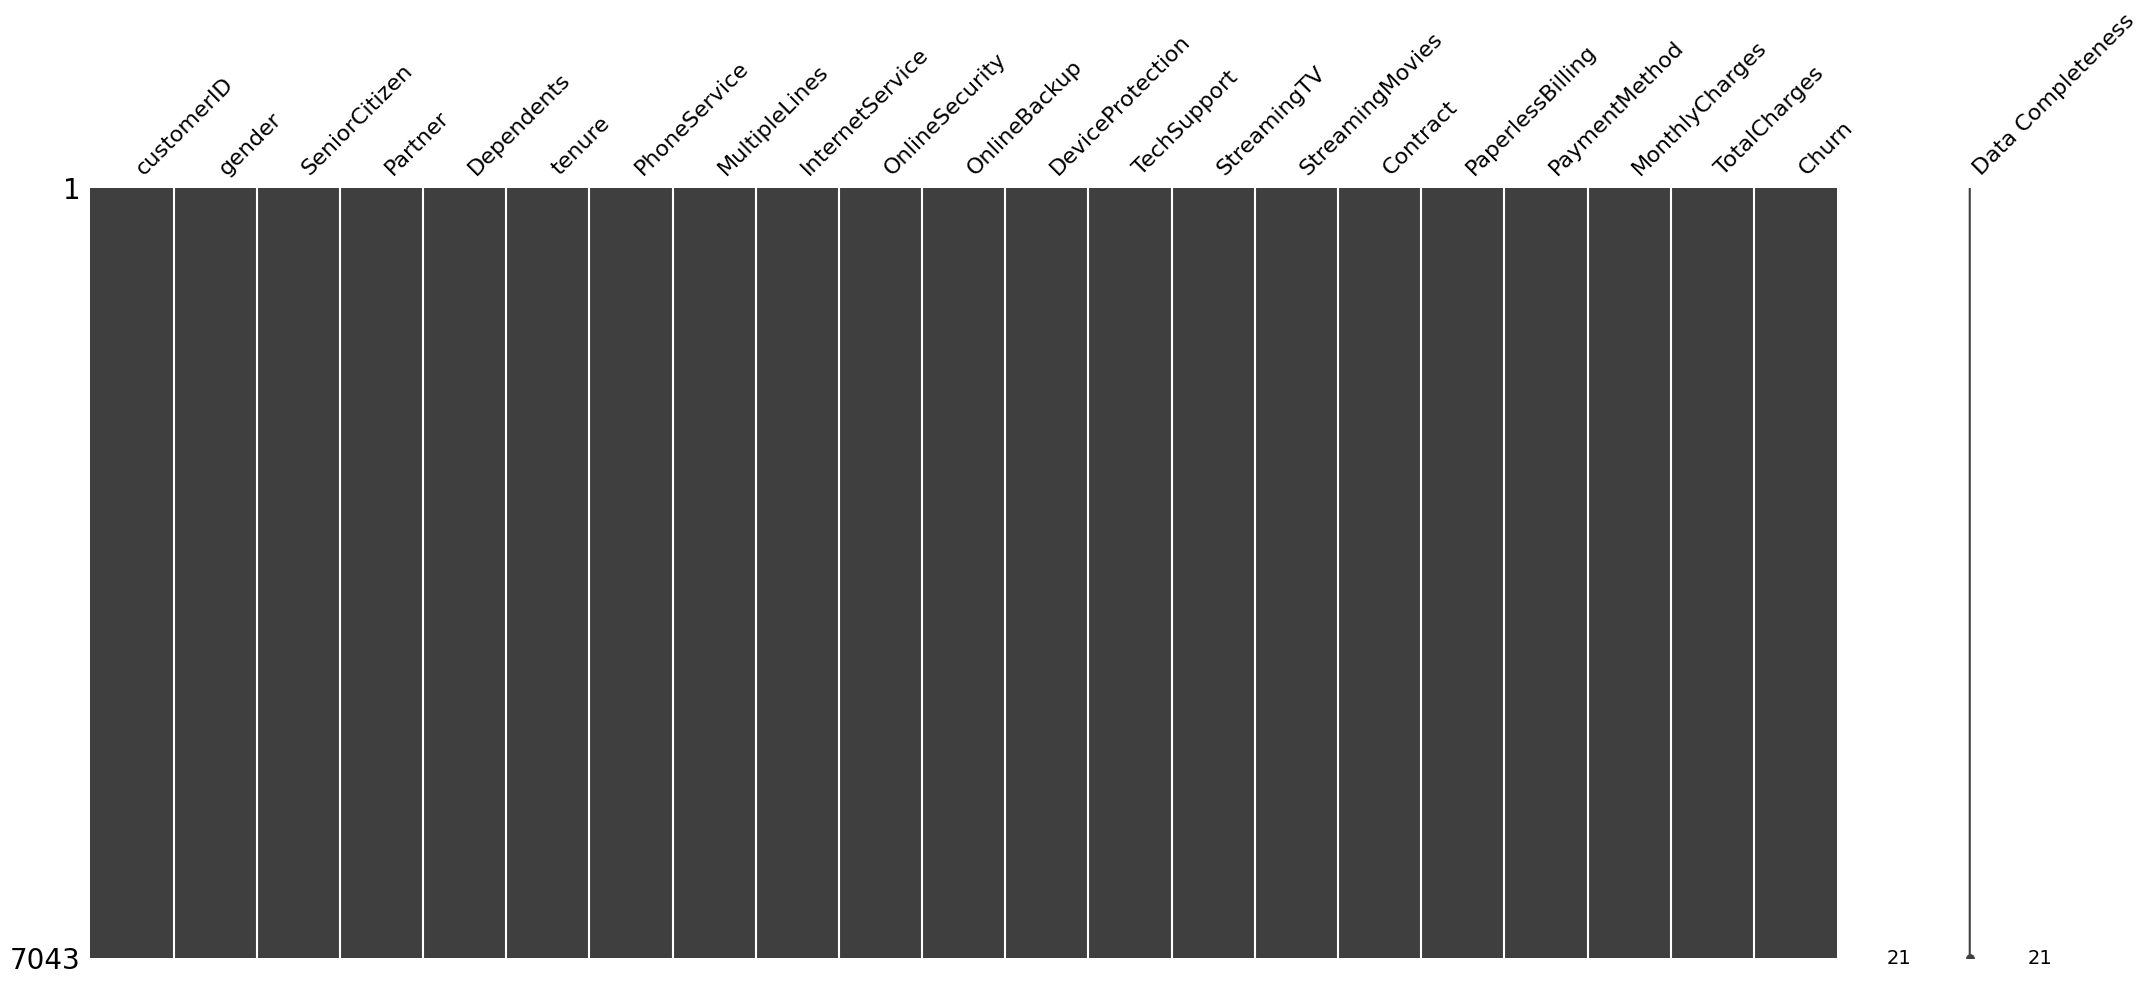

In [ ]:
msno.matrix(df_filled_gaps_mean_value, labels=True)

## Заполнение пропусков на основе данных столбцов MonthlyCharges и Tenure

Очевидно, что значение столбца TotalCharges напрямую зависит от MonthlyCharges и Tenure, а именно:

TotalCharges = Tenure*MonthlyCharges

In [ ]:
df_filled_gaps_analytical_expression = df.copy()
df_missed_value_line = df_filled_gaps_analytical_expression.loc[df['TotalCharges']==' ']
df_missed_value_line.mean()

<ipython-input-8-7e07514a8166>:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_missed_value_line.mean()


SeniorCitizen      0.000000
tenure             0.000000
MonthlyCharges    41.418182
dtype: float64

Видим, что пропуски в столбце TotalChages обусловлены тем, что клиент еще не успел воспользоваться услугам компании (tenure = 0), соответственно, можем заменить пропуски значением 0, поскольку клиент еще не заплатил.

In [ ]:
df_filled_gaps_analytical_expression['TotalCharges'] = pd.to_numeric(df_filled_gaps_analytical_expression['TotalCharges'].str.replace(' ', '0'))

## Анализ на наличие выбросов

In [ ]:
df_filles_gaps = df_filled_gaps_analytical_expression

По остальным столбцам пропусков в данных не наблюдается. Проанализируем числовые данные на наличие выбросов с помощью функии boxplot.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
obj_df = df_filles_gaps.select_dtypes(include=['object'])
obj_df['SeniorCitizen']=df_filles_gaps['SeniorCitizen']
numeric_df = df_filles_gaps.select_dtypes(include=['int64', 'float64']).drop(['SeniorCitizen'], axis=1)

In [ ]:
d = pd.DataFrame(columns = df_filles_gaps.columns)
d[obj_df.columns] = obj_df
d[numeric_df.columns]  = numeric_df

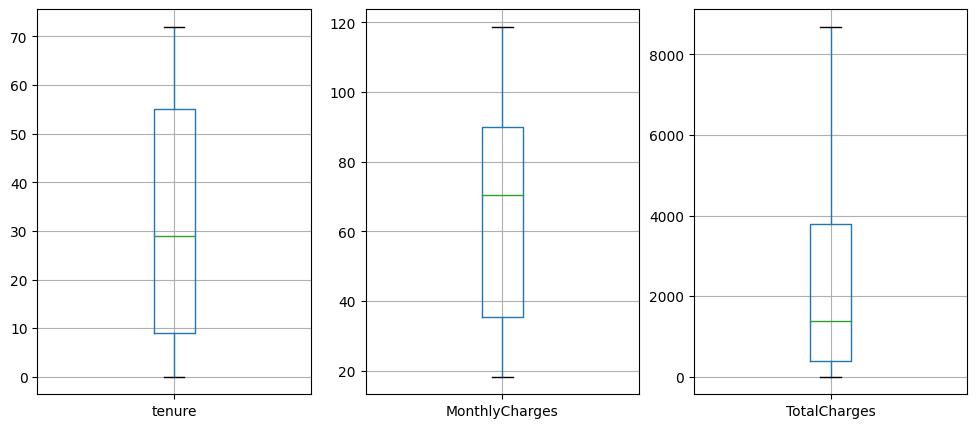

In [ ]:
figure, axis = plt.subplots(1, 3,figsize=(12, 5))
i = 0
for column in numeric_df.columns:
  numeric_df.boxplot([column], ax=axis[i])
  i += 1

Однако, построенные ящики с усами не могут точно утверждать, имеются ли выбросы или нет. На данном этапе мы понимаем, что аномально большие или малые величины в столбцах не представлены. Проверим, какие данные лежат в наборе numeric_df при значении tenure==0 и tenure==1.


In [ ]:
print("Mean TotalCharges: ", round(numeric_df[numeric_df['tenure']==0]['TotalCharges'].mean(), 3))
numeric_df[numeric_df['tenure']==0]

Mean TotalCharges:  0.0


,tenure,MonthlyCharges,TotalCharges
488,0,52.55,0.0
753,0,20.25,0.0
936,0,80.85,0.0
1082,0,25.75,0.0
1340,0,56.05,0.0
3331,0,19.85,0.0
3826,0,25.35,0.0
4380,0,20.00,0.0
5218,0,19.70,0.0
6670,0,73.35,0.0


In [ ]:
print("Mean TotalCharges: ", round(numeric_df[numeric_df['tenure']==1]['TotalCharges'].mean(), 3))
numeric_df[numeric_df['tenure']==1]

Mean TotalCharges:  50.486


,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
20,1,39.65,39.65
22,1,20.15,20.15
27,1,30.20,30.20
33,1,20.20,20.20
...,...,...,...
6979,1,24.20,24.20
7010,1,74.45,74.45
7016,1,49.95,49.95
7018,1,70.65,70.65


In [ ]:
print("Mean TotalCharges: ", round(numeric_df[numeric_df['tenure']==6]['TotalCharges'].mean(), 3))
numeric_df[numeric_df['tenure']==6]

Mean TotalCharges:  336.175


,tenure,MonthlyCharges,TotalCharges
121,6,20.70,112.75
154,6,19.70,113.50
191,6,91.00,531.00
280,6,55.15,322.90
293,6,89.35,567.80
...,...,...,...
6836,6,84.20,519.15
6837,6,79.70,497.60
6878,6,89.50,573.30
6893,6,55.90,365.35


Таким образом, выбросов не обнаружено.

## Дискретизация количественных признаков

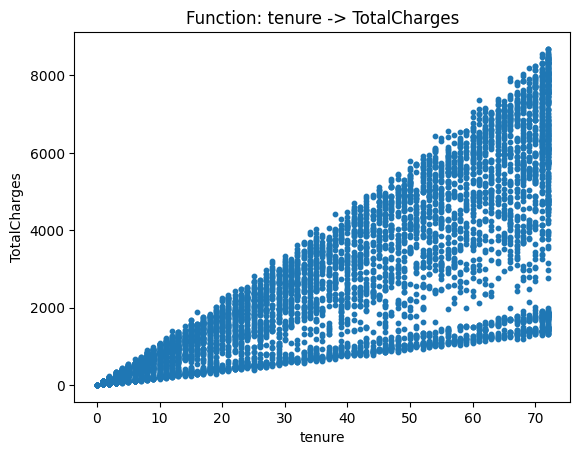

In [ ]:
plt.scatter(numeric_df['tenure'], numeric_df['TotalCharges'], s = 10)
plt.title('Function: tenure -> TotalCharges')
plt.xlabel('tenure')
plt.ylabel('TotalCharges')
plt.show()

Видна четкая зависимость между общей суммой, списанной с клиента, (TotalCharges) и количеством месяцев, в течение которых пользователь оставался в компании (tenure). График имеет вид треугольника из-за наличия в перечне услуг компании тарифов разной стоимости: чем ниже стоимость тарифа, тем меньше клиент заплатил за все время пользования. Рассмотрим теперь значения столбца MonthlyCharges.

<Axes: >

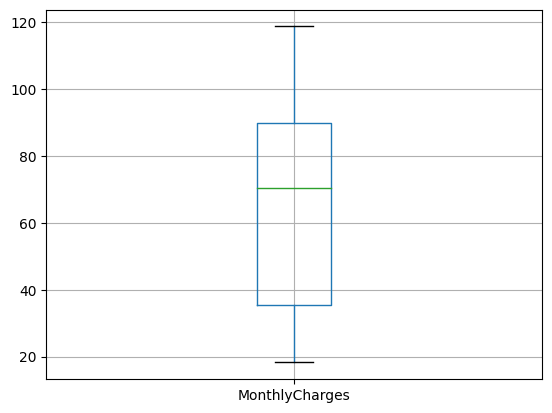

In [ ]:
numeric_df.boxplot(column = 'MonthlyCharges')

In [ ]:
numeric_df.quantile([.0, .25, .5, .75], axis = 0)

,tenure,MonthlyCharges,TotalCharges
0.00,0.0,18.25,0.00
0.25,9.0,35.50,398.55
0.50,29.0,70.35,1394.55
0.75,55.0,89.85,3786.60


In [ ]:
numeric_df_monthlyCharges_group = numeric_df.copy()

Добавим новый столбец в dataset numeric_df_monthlyCharges_group, зависящий от того, в какой диапазон квантилей попадает объект.

In [ ]:
def monthlyCharges_group(monthlyCharge):
  if monthlyCharge < 35.50:
    return 'quantile 0'
  elif monthlyCharge < 70.35:
    return 'quantile 1'
  elif monthlyCharge < 89.85:
    return 'quantile 2'
  else: return 'quantile 3'

numeric_df_monthlyCharges_group['MonthlyChargesGroup'] = numeric_df_monthlyCharges_group['MonthlyCharges'].apply(lambda monthlyCharge: monthlyCharges_group(monthlyCharge))
numeric_df_monthlyCharges_group

,tenure,MonthlyCharges,TotalCharges,MonthlyChargesGroup
0,1,29.85,29.85,quantile 0
1,34,56.95,1889.50,quantile 1
2,2,53.85,108.15,quantile 1
3,45,42.30,1840.75,quantile 1
4,2,70.70,151.65,quantile 2
...,...,...,...,...
7038,24,84.80,1990.50,quantile 2
7039,72,103.20,7362.90,quantile 3
7040,11,29.60,346.45,quantile 0
7041,4,74.40,306.60,quantile 2


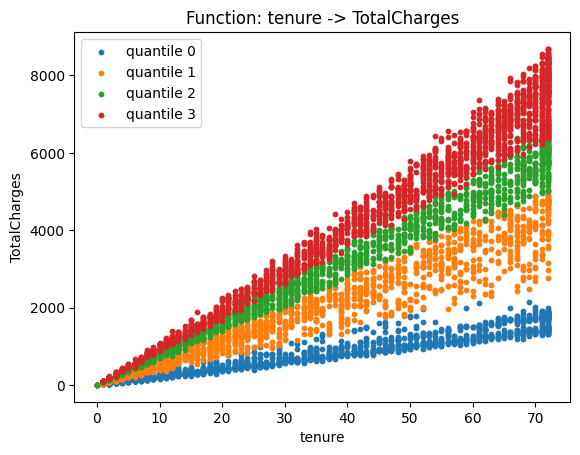

In [ ]:
groups = numeric_df_monthlyCharges_group.groupby('MonthlyChargesGroup')
for name, group in groups:
    plt.scatter(group.tenure, group.TotalCharges, s=10, label=name)
plt.title('Function: tenure -> TotalCharges')
plt.xlabel('tenure')
plt.ylabel('TotalCharges')
plt.legend()
plt.show()

## Анализ на корреляцию признаков

Рассмотрим корреляцию признаков между собой

In [ ]:
import seaborn as sns

In [ ]:
df_heatmap = pd.DataFrame(columns = df.columns)
df_heatmap[obj_df.columns] = obj_df
df_heatmap[numeric_df.columns]  = numeric_df
df_heatmap.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<ipython-input-26-9f361adbb31c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_heatmap.corr())


<Axes: >

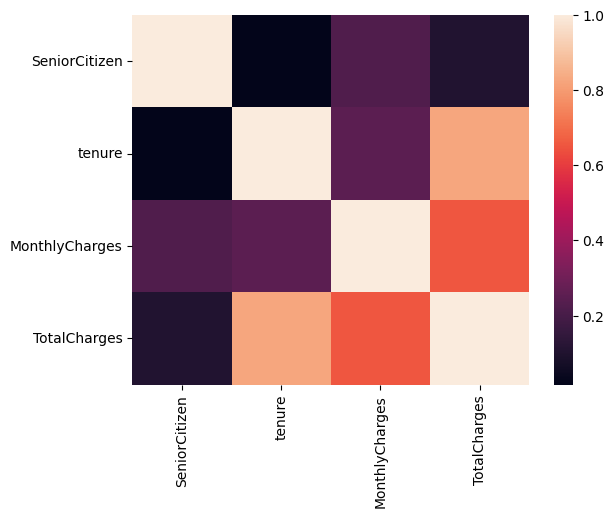

In [ ]:
sns.heatmap(df_heatmap.corr())

Как и предполагалось, наибольшая корреляция наблюдается у пар tenure-TotalCharges и MonthlyCharges-TotalCharges, исключим из выборки столбец TotalCharges.

In [ ]:
numeric_df = numeric_df.drop(['TotalCharges'], axis=1)
df_proccesed = df_heatmap.drop(['TotalCharges'], axis=1)

# Задание 2

Разделите данные на обучающую и тестовую выборки (80/20). На обучающей выборке постройте и сравните между собой несколько вариантов моделей прогнозирования оттока, отличающихся между собой набором предикторов, использованием регуляризации и методом моделирования (например, логистическая регрессия или дерево решений). Используйте для сравнения компонент Test and Score с кросс-валидацией, расчет показателей ошибки классификации и ROC-анализ.
Выберите лучшую модель. Опишите, какие факторы, согласно этой модели, влияют на отток. Для интерпретации можно использовать коэффициенты модели (для логистической регрессии), решающие правила (для деревьев), а также виджет Feature Importance и SHAP-значения для ансамблей.


In [ ]:
data = df_proccesed.drop('customerID', axis=1)
data_obj = obj_df.drop('customerID', axis=1)
data_numeric = numeric_df

## One-Hot кодирование

In [ ]:
data_one_hot_encoded = pd.get_dummies(data_obj, columns=data_obj.columns, drop_first= True)
data_one_hot_encoded[data_numeric.columns]  = data_numeric
data_one_hot_encoded.head()

,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes,SeniorCitizen_1,tenure,MonthlyCharges
0,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,29.85
1,1,0,0,1,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,34,56.95
2,1,0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,1,1,0,2,53.85
3,1,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,45,42.30
4,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,1,0,1,0,2,70.70


## Linear Regression

In [ ]:
from sklearn.model_selection import train_test_split
X = data_one_hot_encoded.drop('Churn_Yes', axis=1)
y = data_one_hot_encoded['Churn_Yes']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
model_reg = LinearRegression()
model_reg.fit(X_train, y_train)

LinearRegression()

Для прогнозироваия оттока клиентов важно НЕ ПРОПУСТИТЬ человека, который в дальнейшем продолжит пользоваться услугами компании, то есть цена ошибки fn больше, чем fp. Для анализа рассматриваемой задачи правильнее воспользоваться метриками Recall и Precision, среди которых предпочтение отдается Recall.

In [ ]:
y_pred = np.round(model_reg.predict(X_test))
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accurancy = accuracy_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("Accurancy:", accurancy)
print("F1-score:", f1score)

Precision: 0.657439446366782
Recall: 0.5080213903743316
Accurancy: 0.7991483321504613
F1-score: 0.5731523378582202


Получаем низкие результатs на метриках Precision и Recall и, наоборот, хорошие результаты Accurancy. Можем сделать вывод, что последняя метрика менее информативна, поскольку требует равномерное распределение меток классов и равную цену fn и fp ответов, что не подходит под решаемую задачу. В дальнейшем будем использовать только RP метрики.

Рассмотрим распределение меток классов в датасете.

In [ ]:
# Доля класса 1 в датасете
sum(y)/len(y)

0.2653698707936959

Таким образом, набор данных не сбалансированный. Для более эффективной работы с ним следует использовать следующие методы: Oversampling, Undersampling, SMOTE или ADASYN

### SMOTE

SMOTE генерирует новые объекты меньшего класса основываясь на методе ближайших соседей. В ходе анализа этот метод показал наилучшие результаты.

In [ ]:
from imblearn.over_sampling import SMOTE

# Создание экземпляра SMOTE
smote = SMOTE()
# Применение увеличения выборки к данным
X_resampled, y_resampled = smote.fit_resample(X, y)
X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [ ]:
model_reg.fit(X_resampled_train, y_resampled_train)
y_resampled_pred = np.round(model_reg.predict(X_resampled_test))
print("Precision:", precision_score(y_resampled_test, y_resampled_pred))
print("Recall:", recall_score(y_resampled_test, y_resampled_pred))
print("F1-score:", f1_score(y_resampled_test, y_resampled_pred))

Precision: 0.7956989247311828
Recall: 0.8579710144927536
F1-score: 0.8256624825662482


### Нормировка данных

In [ ]:
X_norm = (X_resampled-X_resampled.min())/(X_resampled.max()-X_resampled.min())

In [ ]:
X_norm_train = (X_resampled_train-X_resampled_train.min())/(X_resampled_train.max()-X_resampled_train.min())
X_norm_test = (X_resampled_test-X_resampled_test.min())/(X_resampled_test.max()-X_resampled_test.min())

In [ ]:
model_reg.fit(X_norm_train, y_resampled_train)
y_pred = np.round(model_reg.predict(X_norm_test))
print("Precision:", precision_score(y_resampled_test, y_pred))
print("Recall:", recall_score(y_resampled_test, y_pred))
print("F1-score:", f1_score(y_resampled_test, y_pred))

Precision: 0.7772020725388601
Recall: 0.8695652173913043
F1-score: 0.8207934336525307


### Кореляционный анализ

In [ ]:
target_column = 'Churn_Yes'
correlation_with_target = abs(X_resampled.corrwith(y))
correlation_with_target

gender_Male                              0.008612
Partner_Yes                              0.150448
Dependents_Yes                           0.164221
PhoneService_Yes                         0.011942
MultipleLines_No phone service           0.011942
MultipleLines_Yes                        0.040102
InternetService_Fiber optic              0.308020
InternetService_No                       0.227890
OnlineSecurity_No internet service       0.227890
OnlineSecurity_Yes                       0.171226
OnlineBackup_No internet service         0.227890
OnlineBackup_Yes                         0.082255
DeviceProtection_No internet service     0.227890
DeviceProtection_Yes                     0.066160
TechSupport_No internet service          0.227890
TechSupport_Yes                          0.164674
StreamingTV_No internet service          0.227890
StreamingTV_Yes                          0.063228
StreamingMovies_No internet service      0.227890
StreamingMovies_Yes                      0.061382


In [ ]:
correlation_with_target.quantile([.0, .25, .5, .75])

0.00    0.008612
0.25    0.082255
0.50    0.171226
0.75    0.227890
dtype: float64

Рассмотрим, сколько признаков необходимо отбросить для наибольшего повышения точности модели.

In [ ]:
correlation_with_target_df = correlation_with_target.to_frame()
correlation_with_target_df.reset_index(inplace= True )
correlation_with_target_df

,index,0
0,gender_Male,0.008612
1,Partner_Yes,0.150448
2,Dependents_Yes,0.164221
3,PhoneService_Yes,0.011942
4,MultipleLines_No phone service,0.011942
5,MultipleLines_Yes,0.040102
6,InternetService_Fiber optic,0.308020
7,InternetService_No,0.227890
8,OnlineSecurity_No internet service,0.227890
9,OnlineSecurity_Yes,0.171226


In [ ]:
correlation_with_target_df_sorted = correlation_with_target_df.sort_values(by=[0])

# Массив признаков с кореляционным порогом отсечения i = 0.082255, 0.171226 и 0.227890
columns_quantile = [
    correlation_with_target_df_sorted['index'],
    correlation_with_target_df_sorted[correlation_with_target_df_sorted[0]>=0.082255]['index'],
    correlation_with_target_df_sorted[correlation_with_target_df_sorted[0]>=0.171226]['index'],
    correlation_with_target_df_sorted[correlation_with_target_df_sorted[0]>=0.227890]['index'],
]

In [ ]:
for columns in columns_quantile:
  X_corr_train = X_resampled_train[columns]
  X_corr_test = X_resampled_test[columns]
  model_reg.fit(X_corr_train, y_resampled_train)

  y_pred = np.round(model_reg.predict(X_corr_test))
  print("Precision:", precision_score(y_resampled_test, y_pred))
  print("Recall:", recall_score(y_resampled_test, y_pred))
  print("F1-score:", f1_score(y_resampled_test, y_pred))

Precision: 0.7956989247311828
Recall: 0.8579710144927536
F1-score: 0.8256624825662482
Precision: 0.7627118644067796
Recall: 0.8695652173913043
F1-score: 0.8126410835214446
Precision: 0.7493472584856397
Recall: 0.8318840579710145
F1-score: 0.7884615384615385
Precision: 0.7261802575107296
Recall: 0.8173913043478261
F1-score: 0.7690909090909092


Таким образом, наилучший порог отсечения корелляции - 0.082255

In [ ]:
# X_corr = X_resampled[columns_quantile[1]]
# X_corr_train = X_resampled_train[columns_quantile[1]]
# X_corr_test = X_resampled_test[columns_quantile[1]]

X_corr = X_norm[columns_quantile[1]]
X_corr_train = X_norm_train[columns_quantile[1]]
X_corr_test = X_norm_test[columns_quantile[1]]

<Axes: >

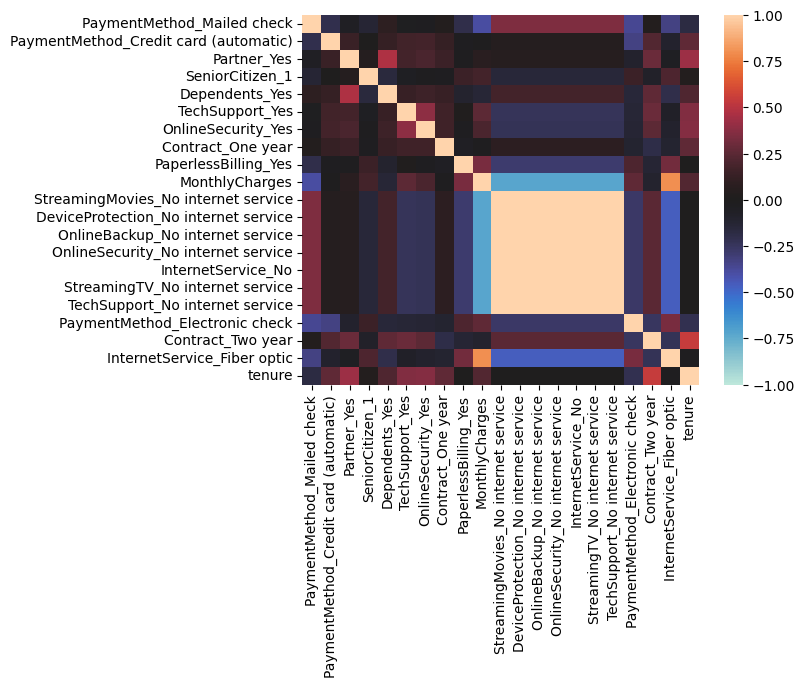

In [ ]:
sns.heatmap(X_corr.corr(), vmin=-1, vmax=1, center= 0)

In [ ]:
X_corr_train.columns

Index(['PaymentMethod_Mailed check', 'PaymentMethod_Credit card (automatic)',
       'Partner_Yes', 'SeniorCitizen_1', 'Dependents_Yes', 'TechSupport_Yes',
       'OnlineSecurity_Yes', 'Contract_One year', 'PaperlessBilling_Yes',
       'MonthlyCharges', 'StreamingMovies_No internet service',
       'DeviceProtection_No internet service',
       'OnlineBackup_No internet service',
       'OnlineSecurity_No internet service', 'InternetService_No',
       'StreamingTV_No internet service', 'TechSupport_No internet service',
       'PaymentMethod_Electronic check', 'Contract_Two year',
       'InternetService_Fiber optic', 'tenure'],
      dtype='object')

In [ ]:
X_corr_train = X_corr_train.drop(['InternetService_Fiber optic',
                   'StreamingMovies_No internet service',
                   'DeviceProtection_No internet service',
                   'OnlineBackup_No internet service',
                   'OnlineSecurity_No internet service',
                   'InternetService_No',
                   'StreamingTV_No internet service'], axis=1)
X_corr_test = X_corr_test.drop(['InternetService_Fiber optic',
                   'StreamingMovies_No internet service',
                   'DeviceProtection_No internet service',
                   'OnlineBackup_No internet service',
                   'OnlineSecurity_No internet service',
                   'InternetService_No',
                   'StreamingTV_No internet service'], axis=1)

In [ ]:
from sklearn.metrics import mean_squared_error
model_reg.fit(X_corr_train, y_resampled_train)
y_pred = np.round(model_reg.predict(X_corr_test))
print("Precision:", precision_score(y_resampled_test, y_pred))
print("Recall:", recall_score(y_resampled_test, y_pred))

Precision: 0.7604690117252931
Recall: 0.8772946859903382


Таким образом, в ходе преобразований (нормировка и удаление неинформативных столбцов) увеличивался Recall - наиболее приоритетная метрика, - и уменьшался (незначительно) Precision.

## Kneighbors

Посмотрим, как KNN работает с данными до семплирования, после семплирования, нормированными и отфильтрованными по значимости признаков данными.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
knn = KNeighborsClassifier()

In [ ]:
# данные до семплирования
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

Precision: 0.5587392550143266
Recall: 0.5213903743315508
F1-score: 0.5394190871369293


In [ ]:
# данные после семплирования
knn.fit(X_resampled_train, y_resampled_train)
y_pred = knn.predict(X_resampled_test)
print("Precision:", precision_score(y_resampled_test, y_pred))
print("Recall:", recall_score(y_resampled_test, y_pred))
print("F1-score:", f1_score(y_resampled_test, y_pred))

Precision: 0.7423409269442263
Recall: 0.9130434782608695
F1-score: 0.8188908145580589


In [ ]:
# данные после нормировки
knn.fit(X_norm_train, y_resampled_train)
y_pred = knn.predict(X_norm_test)
print("Precision:", precision_score(y_resampled_test, y_pred))
print("Recall:", recall_score(y_resampled_test, y_pred))
print("F1-score:", f1_score(y_resampled_test, y_pred))

Precision: 0.7541528239202658
Recall: 0.8772946859903382
F1-score: 0.8110763733809737


In [ ]:
# данные после фильтрации по значимости признаков
knn.fit(X_corr_train, y_resampled_train)
y_pred = knn.predict(X_corr_test)
print("Precision:", precision_score(y_resampled_test, y_pred))
print("Recall:", recall_score(y_resampled_test, y_pred))
print("F1-score:", f1_score(y_resampled_test, y_pred))

Precision: 0.7791970802919708
Recall: 0.8251207729468599
F1-score: 0.8015016424213984


In [ ]:
from sklearn.metrics import fbeta_score
scores = []
for k in range (1, 50):
  knn_k = KNeighborsClassifier(n_neighbors=k)
  y_pred = knn_k.fit(X_resampled_train, y_resampled_train).predict(X_resampled_test)
  scores.append(fbeta_score(y_resampled_test, y_pred, beta=1))

In [ ]:
scores_norm = []
for k in range (1, 50):
  knn_k = KNeighborsClassifier(n_neighbors=k)
  y_pred = knn_k.fit(X_norm_train, y_resampled_train).predict(X_norm_test)
  scores_norm.append(fbeta_score(y_resampled_test, y_pred, beta=1))

In [ ]:
scores_corr = []
for k in range (1, 50):
  knn_k = KNeighborsClassifier(n_neighbors=k)
  y_pred = knn_k.fit(X_corr_train, y_resampled_train).predict(X_corr_test)
  scores_corr.append(fbeta_score(y_resampled_test, y_pred, beta=1))

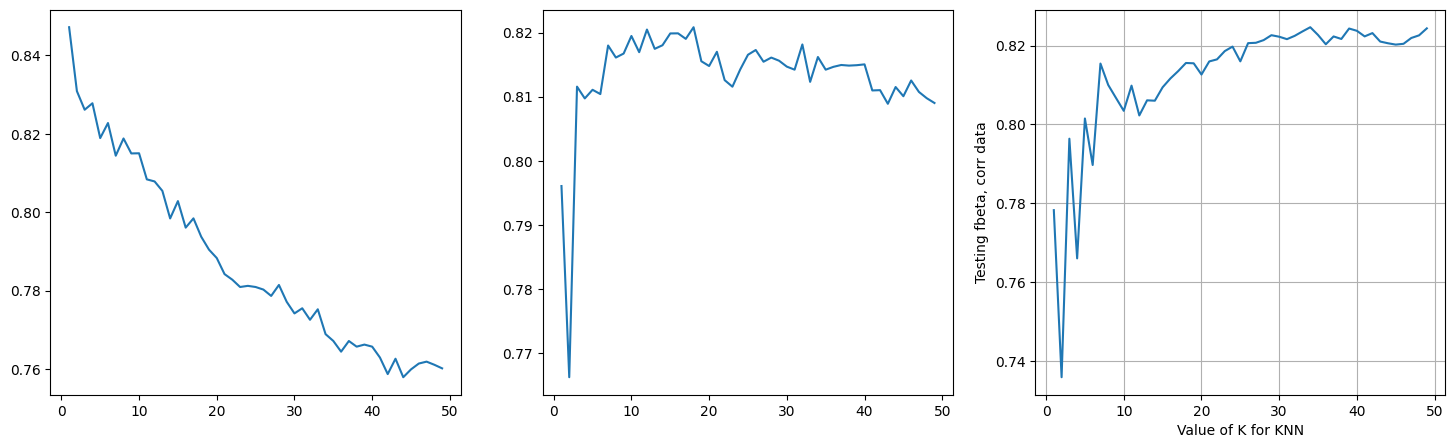

In [ ]:
k_range = list(range(1, 50))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

ax[0].plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing fbeta, resampled data')
plt.grid()

ax[1].plot(k_range, scores_norm)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing fbeta, normalized data')
plt.grid()

ax[2].plot(k_range, scores_corr)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing fbeta, corr data')
plt.grid()

Посмотрим, засчет чего значительно повышается устойчивость классицикации после нормировки данных.

In [ ]:
scores_pr = []
for k in range (1, 50):
  knn_k = KNeighborsClassifier(n_neighbors=k)
  y_pred = knn_k.fit(X_resampled_train, y_resampled_train).predict(X_resampled_test)
  scores_pr.append([precision_score(y_resampled_test, y_pred), recall_score(y_resampled_test, y_pred)])

scores_norm_pr = []
for k in range (1, 50):
  knn_k = KNeighborsClassifier(n_neighbors=k)
  y_pred = knn_k.fit(X_norm_train, y_resampled_train).predict(X_norm_test)
  scores_norm_pr.append([precision_score(y_resampled_test, y_pred), recall_score(y_resampled_test, y_pred)])
scores_corr_pr = []
for k in range (1, 50):
  knn_k = KNeighborsClassifier(n_neighbors=k)
  y_pred = knn_k.fit(X_corr_train, y_resampled_train).predict(X_corr_test)
  scores_corr_pr.append([precision_score(y_resampled_test, y_pred), recall_score(y_resampled_test, y_pred)])

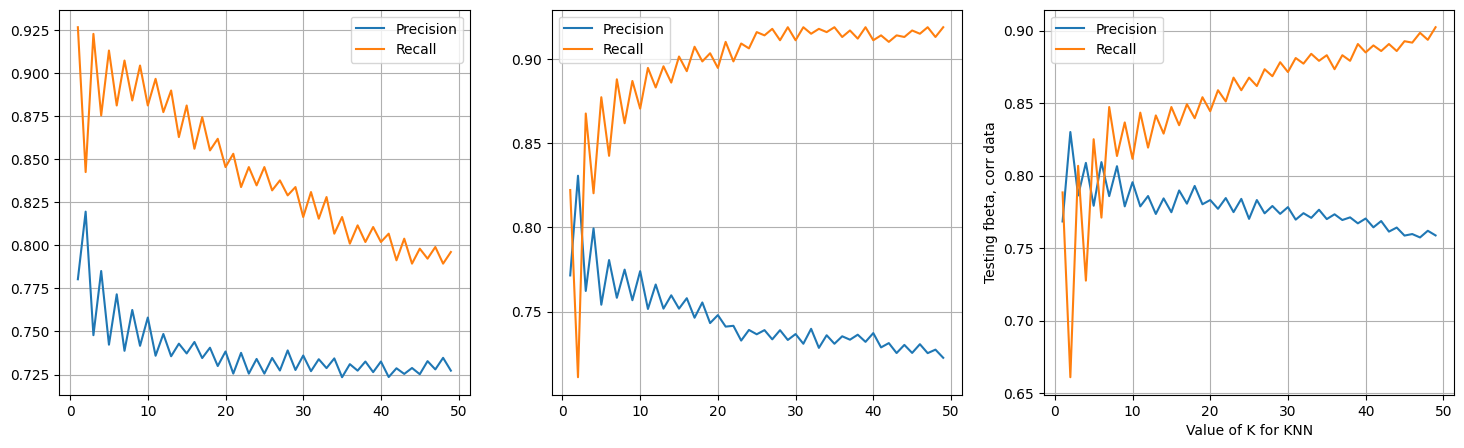

In [ ]:
k_range = list(range(1, 50))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
ax[0].plot(k_range, scores_pr)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing fbeta, resampled data')
ax[0].legend(['Precision', 'Recall'])
ax[0].grid()

ax[1].plot(k_range, scores_norm_pr)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing fbeta, normalized data')
ax[1].legend(['Precision', 'Recall'])
ax[1].grid()

ax[2].plot(k_range, scores_corr_pr)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing fbeta, corr data')
ax[2].legend(['Precision', 'Recall'])
ax[2].grid()

Можно заметить, что вне зависимости от типа предобработки данных (нормировка, удаление неиформативных признаков) при больших k величина Precision находится примерно на одном уровне (72,5%), а значение Recall сильно меняется от нормировки данных. Это говорит о переобучении модели. Посмотрим на формулы Recall и Precision:

$Precision = \frac{TP}{TP+FP}$

$Recall = \frac{TP}{TP+FN}$

Классификатор чаще присваивает метку класса "1" - клиент продолжит пользоваться услугами компании, увеличивая тем самым Recall и уменьшая Precision.

In [ ]:
print("Лучший результат на сэмплированных данных:", round(max(scores), 4), "; k =", scores.index(max(scores))+1)
print("Лучший результат на нормированных данных:", round(max(scores_norm), 4), "; k =", scores_norm.index(max(scores_norm))+1)
print("Лучший результат на отфильтрованных данных:", round(max(scores_corr), 4), "; k =", scores_corr.index(max(scores_corr))+1)

Лучший результат на сэмплированных данных: 0.8472 ; k = 1
Лучший результат на нормированных данных: 0.8208 ; k = 18
Лучший результат на отфильтрованных данных: 0.8246 ; k = 34


## Ансамбли

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_rand_for = RandomForestClassifier(n_estimators=10)
model_rand_for.fit(X_resampled_train, y_resampled_train)
y_pred = model_rand_for.predict(X_resampled_test)
print("Resampled data")
print("Precision:", precision_score(y_resampled_test, y_pred))
print("Recall:", recall_score(y_resampled_test, y_pred))
print("F1-score:", f1_score(y_resampled_test, y_pred))

Resampled data
Precision: 0.8290513833992095
Recall: 0.8106280193236715
F1-score: 0.8197361993160723


In [ ]:
model_rand_for.fit(X_norm_train, y_resampled_train)
y_pred = model_rand_for.predict(X_norm_test)
print("Normed data")
print("Precision:", precision_score(y_resampled_test, y_pred))
print("Recall:", recall_score(y_resampled_test, y_pred))
print("F1-score:", f1_score(y_resampled_test, y_pred))

Normed data
Precision: 0.8257874015748031
Recall: 0.8106280193236715
F1-score: 0.8181374939054119


In [ ]:
model_rand_for.fit(X_corr_train, y_resampled_train)
y_pred = model_rand_for.predict(X_corr_test)
print("Corr data")
print("Precision:", precision_score(y_resampled_test, y_pred))
print("Recall:", recall_score(y_resampled_test, y_pred))
print("F1-score:", f1_score(y_resampled_test, y_pred))

Corr data
Precision: 0.8050436469447139
Recall: 0.8019323671497585
F1-score: 0.8034849951597289


Исследуем, как гиперпараметр n_estimators влияет на точность предсказания в зависимости от типа данных.

In [ ]:
scores_resampled = []
for k in range (1, 70):
  clf = RandomForestClassifier(n_estimators=k)
  y_pred = clf.fit(X_resampled_train, y_resampled_train).predict(X_resampled_test)
  scores_resampled.append(f1_score(y_resampled_test, y_pred))

In [ ]:
scores_norm = []
for k in range (1, 70):
  clf = RandomForestClassifier(n_estimators=k)
  y_pred = clf.fit(X_norm_train, y_resampled_train).predict(X_norm_test)
  scores_norm.append(f1_score(y_resampled_test, y_pred))

In [ ]:
scores_corr = []
for k in range (1, 70):
  clf = RandomForestClassifier(n_estimators=k)
  y_pred = clf.fit(X_corr_train, y_resampled_train).predict(X_corr_test)
  scores_corr.append(f1_score(y_resampled_test, y_pred))

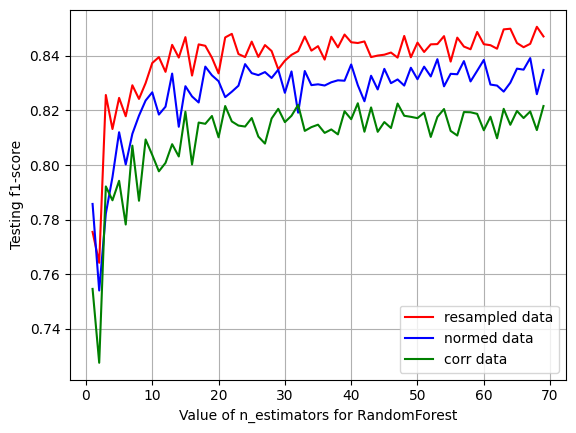

In [ ]:
n_estimators_range = list(range(1, 70))
plt.plot(n_estimators_range, scores_resampled, color='r')
plt.plot(n_estimators_range, scores_norm, color='b')
plt.plot(n_estimators_range, scores_corr, color='g')
plt.xlabel('Value of n_estimators for RandomForest')
plt.ylabel('Testing f1-score')
plt.legend(['resampled data', 'normed data', 'corr data'])
plt.grid()
plt.show()

In [ ]:
print("Лучший результат на сэмплированных данных:", round(max(scores_resampled), 4), "; n_estimators =", scores_resampled.index(max(scores_resampled))+1)
print("Лучший результат на нормированных данных:", round(max(scores_norm), 4), "; n_estimators =", scores_norm.index(max(scores_norm))+1)
print("Лучший результат на отфильтрованных данных:", round(max(scores_corr), 4), "; n_estimators =", scores_corr.index(max(scores_corr))+1)

Лучший результат на сэмплированных данных: 0.8516 ; n_estimators = 69
Лучший результат на нормированных данных: 0.8397 ; n_estimators = 69
Лучший результат на отфильтрованных данных: 0.8233 ; n_estimators = 69


In [ ]:
scores_resampled = []
for k in range (2, 140):
  clf = RandomForestClassifier(n_estimators=40, max_depth = k)
  y_pred = clf.fit(X_resampled_train, y_resampled_train).predict(X_resampled_test)
  scores_resampled.append(f1_score(y_resampled_test, y_pred))

scores_norm = []
for k in range (2, 140):
  clf = RandomForestClassifier(n_estimators=40, max_depth = k)
  y_pred = clf.fit(X_norm_train, y_resampled_train).predict(X_norm_test)
  scores_norm.append(f1_score(y_resampled_test, y_pred))

scores_corr = []
for k in range (2, 140):
  clf = RandomForestClassifier(n_estimators=40, max_depth = k)
  y_pred = clf.fit(X_corr_train, y_resampled_train).predict(X_corr_test)
  scores_corr.append(f1_score(y_resampled_test, y_pred))

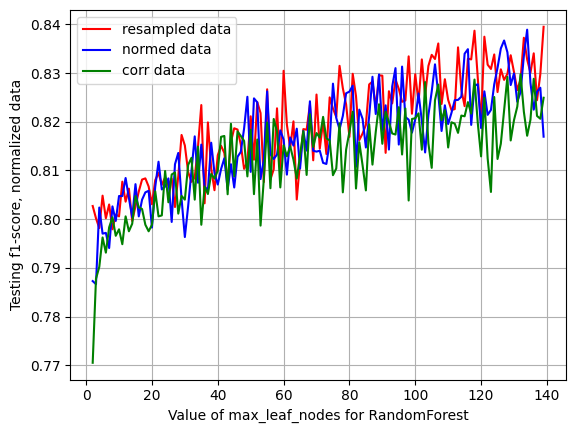

In [ ]:
max_leaf_nodes_range = list(range(2, 140))
plt.plot(max_leaf_nodes_range, scores_resampled, color='r')
plt.plot(max_leaf_nodes_range, scores_norm, color='b')
plt.plot(max_leaf_nodes_range, scores_corr, color='g')
plt.xlabel('Value of max_leaf_nodes for RandomForest')
plt.ylabel('Testing f1-score')
plt.legend(['resampled data', 'normed data', 'corr data'])
plt.grid()
plt.show()

Видим, что вне зависимости от типа предобработки данных, в итоге обучаются они схожим образом. Наибольшая точность предсказаний достигается на семплированных данных.

Построим зависимость количества деревьев в ансамбле от глубины дерева при максимально возможной точности (глубина дерева = const).

In [ ]:
score_deep_cnt = []
for max_leaf_nodes in range (2, 100):
  score_max_leaf_nodes_i = []
  for n_estimators in range(1, 50):
    clf = RandomForestClassifier(n_estimators=n_estimators, max_leaf_nodes = max_leaf_nodes)
    y_pred = clf.fit(X_resampled_train, y_resampled_train).predict(X_resampled_test)
    score_max_leaf_nodes_i.append(f1_score(y_resampled_test, y_pred))
  score_deep_cnt.append([max(score_max_leaf_nodes_i), score_max_leaf_nodes_i.index(max(score_max_leaf_nodes_i))+1])

In [ ]:
scor = []
estimators = []
for i in score_deep_cnt:
  scor.append(i[0])
  estimators.append(i[1])

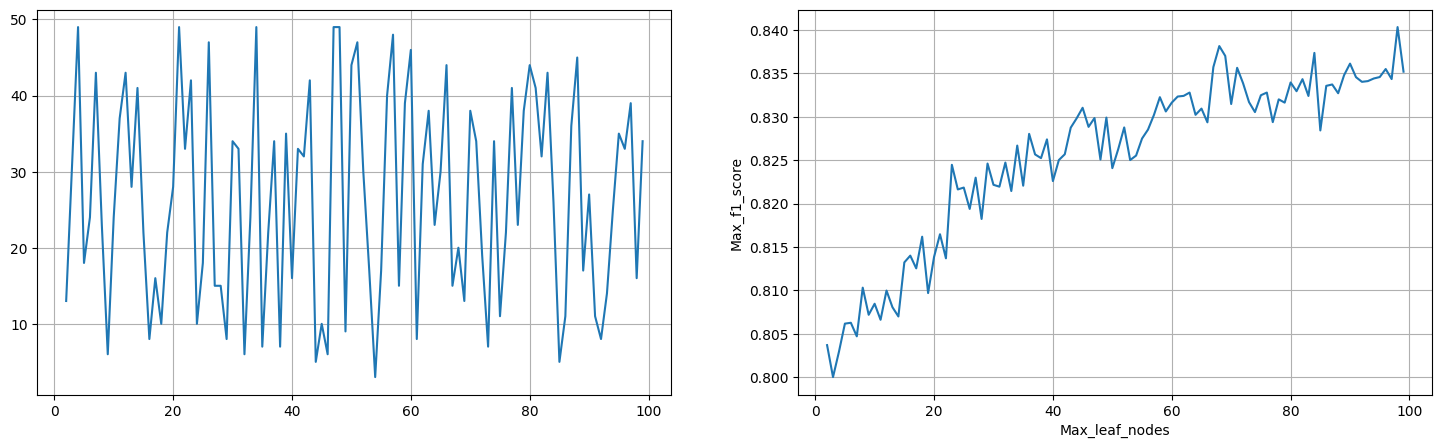

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
max_leaf_nodes = list(range(2, 100))
ax[0].plot(max_leaf_nodes, estimators)
plt.xlabel('Max_leaf_nodes')
plt.ylabel('N_esimators')
ax[0].grid()

ax[1].plot(max_leaf_nodes, scor)
plt.xlabel('Max_leaf_nodes')
plt.ylabel('Max_f1_score')
ax[1].grid()